In [1]:
# TensorFlow and tf.keras

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
import math
import numbers
import time

2.0.0-alpha0


In [2]:
def make_circles(grid = 11, n_data = 10):    
    max_distance = int((grid-1)/2)
    radii = np.random.randint(max_distance/4.,max_distance,size = (n_data, 2))
    radii = radii.flatten()
    distance = np.random.randint(max_distance, size = n_data)
    distances = np.array([np.multiply(np.ones(shape = (grid,grid)),y) for y in distance])
    radii1 = np.array([np.multiply(np.ones(shape = (grid,grid)),y) for y in radii[::2]])
    radii2 = np.array([np.multiply(np.ones(shape = (grid,grid)),y) for y in radii[1::2]])
    circle = np.zeros((n_data, grid, grid))
    circlex = np.zeros((grid, grid))
    circley = np.zeros((grid, grid))
    circlex[:][:][:] = np.arange(grid)
    circley[:][:][:] = np.transpose(circlex)
    x1 = circley - max_distance + distances/2
    x2 = circley - max_distance - distances/2
    y = circlex - max_distance
    position1 = np.sqrt(x1**2+y**2)
    position2 = np.sqrt(x2**2+y**2)
    fill1 = position1 <= radii1
    fill2 = position2 <= radii2
    p1 = np.exp((-1./2.)*(3.*position1/radii1)**2.)
    p2 = np.exp((-1./2.)*(3.*position2/radii2)**2.)
    p1 = np.where(fill1, p1, 0.0)
    p2 = np.where(fill2, p2, 0.0)
    circles = p1 + p2
    circles = circles.reshape(n_data, grid**2)
    radii = radii.reshape(n_data, 2)
    distances = distances.reshape(n_data*grid**2,1)[::grid**2]
    return circles, radii, distances
    

Make data:

In [3]:
grid = 100
n_data = 500
toc = time.clock()
circleData, radiiLabels, distanceLabels = make_circles(grid, n_data)
tic = time.clock()
print(tic-toc)

0.663993


Print a plot of data to see what it looks like!

radius = 
[28 45]
distance between centers = 
[31.]


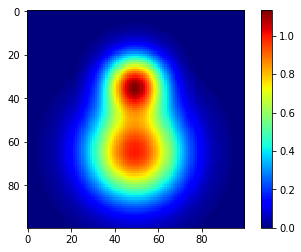

In [4]:
display = circleData[60].reshape(grid,grid)
plt.grid(False)
plt.imshow(display, cmap = 'jet')
print("radius = ")
print(radiiLabels[60])
print("distance between centers = ")
print(distanceLabels[60])
plt.colorbar()

Preprocessing -> spit data into training and testing; take 80% for training and 20% for testing.

If using CNN, uncomment ".reshape(n_data, grid, grid, 1)".

In [5]:
distanceData = circleData#.reshape(n_data, grid, grid, 1)

split = int(0.8*len(circleData))
train_data = distanceData[:split]
train_labels = distanceLabels[:split]
print (train_data.shape)
test_data = distanceData[split:]
print(test_data.shape)
test_labels = distanceLabels[split:]

(400, 10000)
(100, 10000)


Build DNN:

In [6]:
def build_model():
  model = keras.Sequential([
    #layers.Conv2D(32, (3, 3), activation='relu'),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    #layers.Flatten(),
    layers.Dense(64, activation=tf.nn.relu), 
    layers.Dense(64, activation=tf.nn.relu), 
    layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics=['mean_squared_error', 'mean_absolute_error'])
  return model

Initialize model:

In [7]:
model_circ = build_model()

Test model's prediction $before$ training:

In [8]:
example_batch = train_data[:10]
example_labels = train_labels[:10]
example_result = model_circ.predict(example_batch)
results = model_circ.evaluate(example_batch, example_labels)
example_result

10/10 [==============================] - 0s 5ms/sample - loss: 383.1699 - mean_squared_error: 383.1699 - mean_absolute_error: 16.2670


array([[-0.11884242],
       [-0.01434052],
       [-0.10911839],
       [-0.04135467],
       [ 0.01965319],
       [-0.11258323],
       [-0.07230471],
       [-0.08470258],
       [-0.11335191],
       [-0.022841  ]], dtype=float32)

Now train! (warning: if building CNN, computer tends to get loud)

In [9]:
 class PrintDot(keras.callbacks.Callback):
   def on_epoch_end(self, epoch, logs):
     if epoch % 100 == 0: 
         print('')
     print('.', end='')
    
 EPOCHS = 100

 history = model_circ.fit(
   train_data, train_labels,
   epochs=EPOCHS, validation_split = 0.2, verbose = 0,
   callbacks=[PrintDot()])


....................................................................................................

Now make a plot that shows the pregression of accuracy through each training epoch.

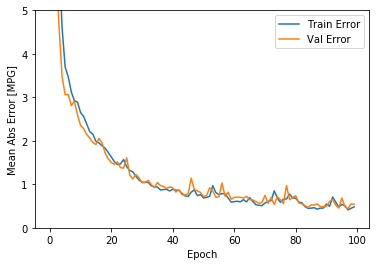

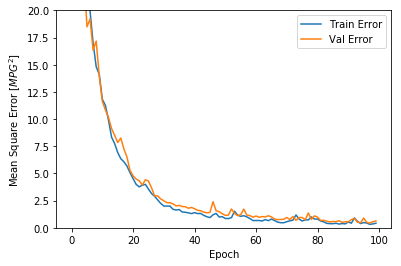

In [10]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

Now have the model train with "early stopping". the tensorflow "early stopping" function has the training stop according to a monitor. In our case, we are stopping it when the monitor sees an insufficient change in variable loss within the last ten epochs.


....................................................................................................
.................................

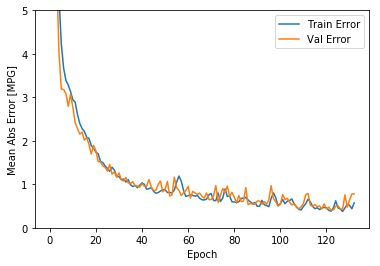

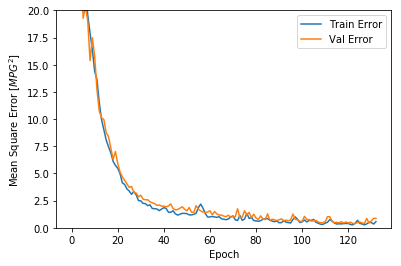

In [11]:
model_circ = build_model()
EPOCHS = 1000
#The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history_earlyStop = model_circ.fit(train_data, train_labels, epochs=EPOCHS,
                   validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])
plot_history(history_earlyStop)

In [12]:
results = model_circ.evaluate(test_data, test_labels)

100/100 [==============================] - 0s 90us/sample - loss: 0.9504 - mean_squared_error: 0.9504 - mean_absolute_error: 0.7875


Evaluate the performance of our DNN! Plot predictions vs. true values (the line is predictions vs. predicitons).

Multilayer perceptron: initial MSE ~ 656.7611; final MSE ~ 0.8408.

CNN: initial MSE ~ 1170.2961; final MSE ~ 1.6238.

CNN w/ MaxPooling layer: initial MSE ~ 1167.0415; final ~ MSE 0.4101.

CNN w/ AveragePooling layer: initial MSE ~ 804.62; final ~ 0.78.

100/100 [==============================] - 0s 73us/sample - loss: 0.9504 - mean_squared_error: 0.9504 - mean_absolute_error: 0.7875


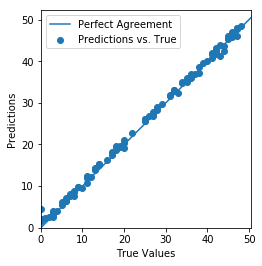

In [13]:
test_predictions = model_circ.predict(test_data)
results = model_circ.evaluate(test_data, test_labels)
plt.scatter(test_labels.flatten(), test_predictions.flatten(), label = 'Predictions vs. True')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100], label="Perfect Agreement")
plt.legend(loc='upper left')

Now let's use the same network to predict radii!

To use CNN, uncomment ".reshape(n_data, grid, grid, 1)"

In [24]:
radData = circleData#.reshape(n_data, grid, grid, 1)
split = int(0.8*len(radData))
train_data_rad = radData[:split]
print(train_data_rad.shape)
train_labels_rad = radiiLabels[:split]
test_data_rad = radData[split:]
test_labels_rad = radiiLabels[split:]

(400, 10000)


To implement basic CNN, uncomment "layers.Conv2D(32, (3, 3), activation='relu'), layers.Conv2D(64, (3, 3)," and "layers.Flatten()"

To implement MaxPooling CNN, uncomment "layers.Conv2D(32, (3, 3), activation='relu'), layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2))," and "layers.Flatten()"


In [15]:
def build_model_rad():
  model = keras.Sequential([
    #ayers.Conv2D(32, (3, 3), activation='relu'),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(32, (3, 3), activation='relu'),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(32, (3, 3), activation='relu'),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    #layers.Flatten(),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(2)
  ])

  model.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics=['mean_absolute_error', 'mean_squared_error', 'accuracy'])
  return model

In [16]:
model_rad = build_model_rad()
example_batch = train_data_rad[:10]
example_labels = train_labels_rad[:10]
example_result = model_rad.predict(example_batch)
results = model_rad.evaluate(example_batch, example_labels)
example_result

10/10 [==============================] - 0s 6ms/sample - loss: 1040.8875 - mean_absolute_error: 30.6083 - mean_squared_error: 1040.8875 - accuracy: 0.6000


array([[-0.04552487,  0.6446403 ],
       [-0.05844562,  0.80653214],
       [-0.08488492,  0.6811029 ],
       [-0.1298213 ,  0.62234783],
       [-0.32636455,  1.209933  ],
       [-0.17708492,  0.9711436 ],
       [-0.3336876 ,  1.0984061 ],
       [-0.14185259,  1.0789578 ],
       [-0.08575089,  0.7107213 ],
       [-0.07392461,  0.46747923]], dtype=float32)

For more information while the network is running, such as real time validation error, set "verbose = 1".


....................................................................................................Training time = 
12.621066


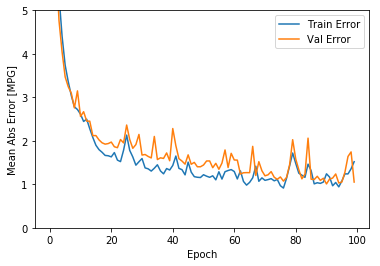

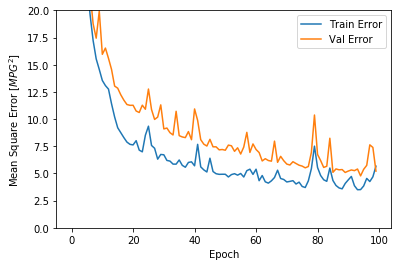

In [17]:
EPOCHS = 100
toc = time.clock()
history = model_rad.fit(
  train_data_rad, train_labels_rad,
  epochs=EPOCHS, validation_split = 0.2, verbose = 0,
  callbacks=[PrintDot()])
tic = time.clock()
print('Training time = ')
print(tic-toc)
plot_history(history)

For epochs = 1000, the above plot is a good example of how the error on the validation data can actually increase after a certain epoch-value is reached.

Train on 320 samples, validate on 80 samples
Epoch 1/1000
320/320 [==============================] - 0s 851us/sample - loss: 487.6187 - mean_absolute_error: 19.2519 - mean_squared_error: 487.6187 - accuracy: 0.4969 - val_loss: 99.0826 - val_mean_absolute_error: 8.5783 - val_mean_squared_error: 99.0826 - val_accuracy: 0.4500
Epoch 2/1000
320/320 [==============================] - 0s 119us/sample - loss: 129.6324 - mean_absolute_error: 9.2777 - mean_squared_error: 129.6324 - accuracy: 0.6500 - val_loss: 78.7544 - val_mean_absolute_error: 7.4311 - val_mean_squared_error: 78.7544 - val_accuracy: 0.7250
Epoch 3/1000
320/320 [==============================] - 0s 117us/sample - loss: 62.8525 - mean_absolute_error: 6.6336 - mean_squared_error: 62.8525 - accuracy: 0.8062 - val_loss: 62.4812 - val_mean_absolute_error: 6.6770 - val_mean_squared_error: 62.4812 - val_accuracy: 0.8375
Epoch 4/1000
320/320 [==============================] - 0s 118us/sample - loss: 43.7808 - mean_absolute_error: 5.484

Epoch 30/1000
320/320 [==============================] - 0s 115us/sample - loss: 7.1577 - mean_absolute_error: 1.6458 - mean_squared_error: 7.1577 - accuracy: 0.9344 - val_loss: 11.3350 - val_mean_absolute_error: 2.1977 - val_mean_squared_error: 11.3350 - val_accuracy: 0.8500
Epoch 31/1000
320/320 [==============================] - 0s 116us/sample - loss: 7.9164 - mean_absolute_error: 1.7576 - mean_squared_error: 7.9164 - accuracy: 0.9250 - val_loss: 10.3485 - val_mean_absolute_error: 1.8839 - val_mean_squared_error: 10.3485 - val_accuracy: 0.9000
Epoch 32/1000
320/320 [==============================] - 0s 115us/sample - loss: 7.2238 - mean_absolute_error: 1.6906 - mean_squared_error: 7.2238 - accuracy: 0.9344 - val_loss: 10.7746 - val_mean_absolute_error: 2.0377 - val_mean_squared_error: 10.7746 - val_accuracy: 0.8750
Epoch 33/1000
320/320 [==============================] - 0s 116us/sample - loss: 7.5280 - mean_absolute_error: 1.8146 - mean_squared_error: 7.5280 - accuracy: 0.9219 - v

Epoch 60/1000
320/320 [==============================] - 0s 120us/sample - loss: 5.7869 - mean_absolute_error: 1.4734 - mean_squared_error: 5.7869 - accuracy: 0.9375 - val_loss: 7.0173 - val_mean_absolute_error: 1.4316 - val_mean_squared_error: 7.0173 - val_accuracy: 0.9375
Epoch 61/1000
320/320 [==============================] - 0s 116us/sample - loss: 5.8589 - mean_absolute_error: 1.4339 - mean_squared_error: 5.8589 - accuracy: 0.9344 - val_loss: 7.5608 - val_mean_absolute_error: 1.6581 - val_mean_squared_error: 7.5608 - val_accuracy: 0.8875
Epoch 62/1000
320/320 [==============================] - 0s 120us/sample - loss: 5.5613 - mean_absolute_error: 1.3461 - mean_squared_error: 5.5613 - accuracy: 0.9438 - val_loss: 8.3359 - val_mean_absolute_error: 1.8649 - val_mean_squared_error: 8.3359 - val_accuracy: 0.8250
Epoch 63/1000
320/320 [==============================] - 0s 117us/sample - loss: 5.8079 - mean_absolute_error: 1.5077 - mean_squared_error: 5.8079 - accuracy: 0.9344 - val_los

Epoch 90/1000
320/320 [==============================] - 0s 115us/sample - loss: 4.2375 - mean_absolute_error: 1.0293 - mean_squared_error: 4.2375 - accuracy: 0.9781 - val_loss: 6.0480 - val_mean_absolute_error: 1.3104 - val_mean_squared_error: 6.0480 - val_accuracy: 0.9625
Epoch 91/1000
320/320 [==============================] - 0s 116us/sample - loss: 4.8681 - mean_absolute_error: 1.2737 - mean_squared_error: 4.8681 - accuracy: 0.9438 - val_loss: 8.3407 - val_mean_absolute_error: 1.9167 - val_mean_squared_error: 8.3407 - val_accuracy: 0.9375
Epoch 92/1000
320/320 [==============================] - 0s 115us/sample - loss: 4.7201 - mean_absolute_error: 1.2730 - mean_squared_error: 4.7201 - accuracy: 0.9563 - val_loss: 6.3531 - val_mean_absolute_error: 1.4635 - val_mean_squared_error: 6.3531 - val_accuracy: 0.9625
Epoch 93/1000
320/320 [==============================] - 0s 117us/sample - loss: 4.0063 - mean_absolute_error: 1.0840 - mean_squared_error: 4.0063 - accuracy: 0.9656 - val_los

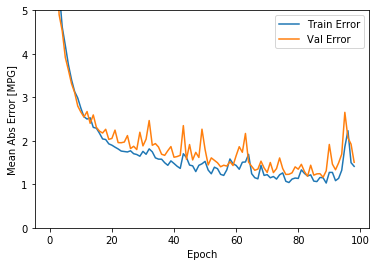

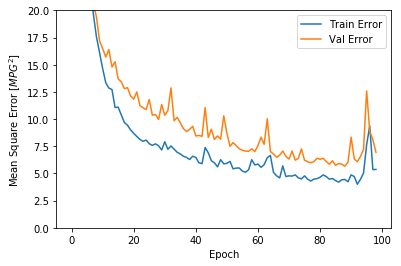

In [18]:
model_rad = build_model_rad()
EPOCHS = 1000
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

toc = time.clock()

history = model_rad.fit(train_data_rad, train_labels_rad, epochs=EPOCHS,
                    validation_split = 0.2, verbose=1, callbacks=[early_stop, PrintDot()])
tic = time.clock()

print('Training time = ')
print(tic-toc)
plot_history(history)

In [19]:
results = model_rad.evaluate(test_data_rad, test_labels_rad)
print(results)

100/100 [==============================] - 0s 88us/sample - loss: 7.0579 - mean_absolute_error: 1.4799 - mean_squared_error: 7.0579 - accuracy: 0.9100
[7.057908420562744, 1.4798758, 7.0579085, 0.91]


Multilayer perceptron: final accuracy ~ 93%; initial MSE ~ 1019.7198 ; final MSE ~ 7.7464.

CNN: final accuracy ~ 96%; intitial MSE ~ 797.3132; final MSE ~ 4.2162.

CNN w/ MaxPooling layer: final accuracy ~ 97%; initial MSE ~ 800.8616; final MSE ~ 3.8766.

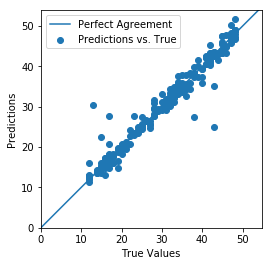

In [20]:
test_predictions_rad = model_rad.predict(test_data_rad)
test_labels_plot = test_labels_rad.flatten()
plt.scatter(test_labels_plot, test_predictions_rad.flatten(), label='Predictions vs. True')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100], label="Perfect Agreement")
plt.legend(loc='upper left')